Using Enric's data with CNN LeNet model
- sampling rate is 5kHz
- 


- will use 12kHz files since the normal data is in 12kHz
- images are 16*16 since 12kHz have less samples
- loading from CWRU_16.pickle
- normalizing data between [0,1] instead of [0,255]

In [34]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Install Neptune Client
! pip install neptune-client
! pip install neptune-tensorflow-keras
! pip install neptune-contrib
#! pip install neptune-sklearn
! pip install psutil
#! pip install scikit-plot

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [35]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import signal
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

import os
import datetime

from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import class_weight

import copy

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
#import neptune.new.integrations.sklearn as npt_utils

#import scikitplot as skplt
#from scikitplot.metrics import plot_confusion_matrix, plot_roc


## GLOBAL SEED ##   
np.random.seed(1)                                                
tf.random.set_seed(1)
sklearn_seed = 42
print(tf.version.VERSION)

M = 64
N = 2
sample_rate = 5000

2.5.0


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# https://stackoverflow.com/questions/54379184/importing-an-entire-folder-of-py-files-into-google-colab
# https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter
%cd /content/drive/MyDrive/Colab\ Notebooks/Thesis
import knightec_py3

/content/drive/MyDrive/Colab Notebooks/Thesis


In [38]:
# CWRU.pickle is a list with ALL of the data
#pickle_name = 'knightec_{}.pickle'.format(M)
pickle_name = 'knightec_100_5000_{}.pickle'.format(M)
with open(pickle_name, 'rb') as f:
  data = pickle.load(f)

In [39]:
thesis_dir = os.getcwd()
current_dir = "5_Knightec_CNN_LeNet"
file_name = "Knightec_CNN_LeNet_1"
rdir = os.path.join(os.path.expanduser(thesis_dir), current_dir)
rdir

'/content/drive/MyDrive/Colab Notebooks/Thesis/5_Knightec_CNN_LeNet'

Obtain normal data and split for each of the different loads.

In [40]:
data.X_v2x_train.shape

(66, 4096)

combine the data from all 3 accelerometer axis

In [41]:
def merge_vib_axis(data):
  X_train = np.concatenate((np.concatenate((data.X_v2x_train, data.X_v2y_train)), data.X_v2z_train))
  X_test = np.concatenate((np.concatenate((data.X_v2x_test, data.X_v2y_test)), data.X_v2z_test))
  print(X_train.shape)
  print(X_test.shape)

  y_train = data.y_train + data.y_train + data.y_train
  y_test = data.y_test + data.y_test + data.y_test
  print(len(y_train))
  print(len(y_test))
  return X_train, X_test, y_train, y_test

In [42]:
X_train = np.concatenate((np.concatenate((data.X_v2x_train, data.X_v2y_train)), data.X_v2z_train))
X_test = np.concatenate((np.concatenate((data.X_v2x_test, data.X_v2y_test)), data.X_v2z_test))
print(X_train.shape)
print(X_test.shape)

y_train = data.y_train + data.y_train + data.y_train
y_test = data.y_test + data.y_test + data.y_test
print(len(y_train))
print(len(y_test))

(198, 4096)
(99, 4096)
198
99


Split training set into train / validation.
NOTE! Will skip this step as it is automatically done when training the model.

In [43]:
# Split training data into training and validatiom
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2, random_state=sklearn_seed,
                                                  shuffle=False, stratify=None)
print(X_train.shape)
print(X_val.shape)

(198, 4096)
(158, 4096)
(40, 4096)


In [44]:
slice_size = M*M
T = 1.0 / sample_rate
N = (2 - 0) * sample_rate
time = np.linspace(0, 2, N)

In [45]:
# Use DataFrame for better manipulation
#data_columns = ["0.007B", "0.007IR", "0.007OR12", "0.007OR3", "0.007OR6", "0.014B", "0.014IR", "0.014OR6", "0.021B", "0.021IR", "0.021OR12", "0.021OR3", "0.021OR6", "Normal"]
df = pd.DataFrame(X_val[0])
df.index.name = "Cycles"
# print(df)
print(df.shape)
df.head(5)

(4096, 1)


,0
Cycles,
0,0.172
1,-0.048
2,-0.307
3,-0.153
4,0.077


In [46]:
df.describe()

,0
count,4096.000000
mean,-0.234081
std,0.263192
min,-1.331000
25%,-0.402000
50%,-0.230000
75%,-0.048000
max,0.747000


In [47]:
minVal = df.min()
minVal.sort_values()
#df = df.drop(df.index[3123])

0   -1.331
dtype: float64

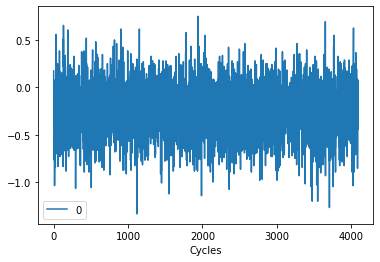

In [48]:
df.plot()

In [49]:
def to_image(df, M, N=2):
    """
    single image conversion from dataframe[0:M*M] to M*M ndarray
    :param df:
    :param M:
    :return:
    """
    P = df.values.reshape(M, M)
    if N==0:
      P = np.round((P-np.min(df.values)/(np.max(df.values)-np.min(df.values)))*255)
    elif N==1:
      P = (P-np.min(df.values))/(np.max(df.values)-np.min(df.values))
    elif N==2:
      P = P-np.min(df.values)/(np.max(df.values)-np.min(df.values))
    else:
      P = df

    return P

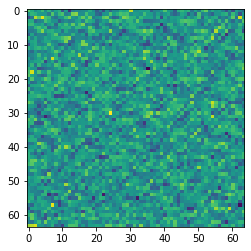

In [50]:
# Convert dataframe element to image for testing purposes
data_to_convert = df[0:(M*M)]
data_image = to_image(data_to_convert, M)
# plt.imshow(data_image, cmap='gray')
plt.imshow(data_image)
plt.show()


In [51]:
# data_image

In [90]:
def to_images(data, N=2):
    """
    Converts time-series data into normalized images
    :param data:
    :return:
    """
    min_val = np.amin(data, axis=1).reshape(-1, 1)
    max_val = np.amax(data, axis=1).reshape(-1, 1)
    if N==0:
      P = np.around(((data-min_val) / (max_val-min_val)) * 255)
    elif N==1:
      P = (data-min_val) / (max_val-min_val)
    elif N==2:
      P = data-min_val / (max_val-min_val)
    else:
      P = data
      
    return P

In [84]:
def show_images(images, labels, plot=True):
    """
    Creates a collage all class images
    :param images: all images data. ndarray of 64x64 elements
    :param labels: labels of images. 0-13
    :return: none
    """

    image_index, unique_img = [], []
    for i in range(0, len(data.labels)):
        image_index.append(labels.index(i))
        unique_img.append(images[labels.index(i)].squeeze(axis=2))

    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(int(len(data.labels)/2), 3),  # creates 3x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    for i, (ax, im) in enumerate(zip(grid, unique_img)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(data.labels[i])
  
    plt.show()
    return fig

In [54]:
def conv_to_images(X_train, X_test, X_val, N=2, plot=True):
  # convert all time-series slices to images
  train_X = np.array([im.reshape(M, M) for im in to_images(X_train, N)])
  test_X = np.array([im.reshape(M, M) for im in to_images(X_test, N)])
  val_X = np.array([im.reshape(M, M) for im in to_images(X_val, N)])

  # add channel for grayscale
  train_X = train_X[..., np.newaxis]
  test_X = test_X[..., np.newaxis]
  val_X = val_X[..., np.newaxis]

  #display some of the images
  class_images = show_images(train_X, y_train, plot)

  return train_X, test_X, val_X, class_images

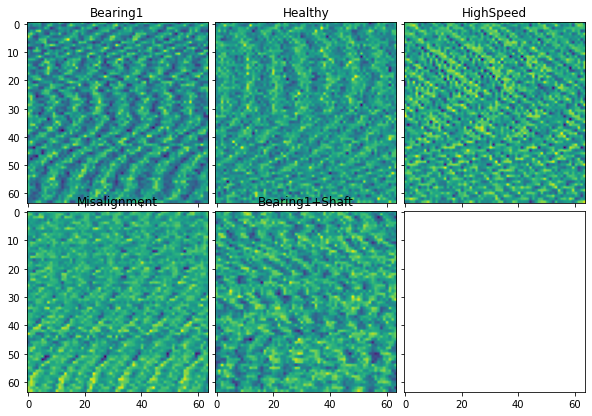

In [55]:
# convert all time-series slices to images
train_X = np.array([im.reshape(M, M) for im in to_images(X_train)])
test_X = np.array([im.reshape(M, M) for im in to_images(X_test)])
val_X = np.array([im.reshape(M, M) for im in to_images(X_val)])

# add channel for grayscale
train_X = train_X[..., np.newaxis]
test_X = test_X[..., np.newaxis]
val_X = val_X[..., np.newaxis]

#display some of the images
class_images = show_images(train_X, y_train)

In [56]:
train_X[0].shape

(64, 64, 1)

In [57]:
# this function can be replaced with Keras builtin to_categorical() function.

def OneHot(y):
    """
        input:  y (n) = labels
        output: onehot (Kxn) = one-hot representation of labels
    """
    onehot = np.zeros((len(data.labels), len(y)))
    for idx, val in enumerate(y):
        onehot[val][idx] = 1
    # print("oneshot {}".format(onehot))
    return onehot

# convert labels to one-hot encoding
train_y = OneHot(y_train).swapaxes(1, 0)
test_y = OneHot(y_test).swapaxes(1, 0)
val_y = OneHot(y_val).swapaxes(1, 0)

In [58]:
# https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.argmax(train_y, axis=1)),
                                                 np.argmax(train_y, axis=1))
class_weight_dict = dict(enumerate(class_weights))

# Lenet-based model based on Paper 2

In [59]:
FD1 = 2560
FD2 = 768

In [60]:
def lenet_64():
    """
    model based on LeNet-5
    activation function is tanh
    :return:
    """
    model = models.Sequential(name='lenet')
    model.add(layers.Conv2D(filters=32, kernel_size=5, input_shape=(M, M, 1), activation="tanh", padding="same", name="L1"))
    model.add(layers.MaxPool2D(pool_size=2, name="L2"))
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation="tanh", padding="same", name="L3"))
    model.add(layers.MaxPool2D(pool_size=2, name="L4"))
    model.add(layers.Conv2D(filters=128, kernel_size=3, activation="tanh", padding="same", name="L5"))
    model.add(layers.MaxPool2D(pool_size=2, name="L6"))
    model.add(layers.Conv2D(filters=256, kernel_size=3, activation="tanh", padding="same", name="L7"))
    model.add(layers.MaxPool2D(pool_size=2, name="L8"))
    model.add(layers.Flatten())
    model.add(layers.Dense(2560, activation='tanh'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(768, activation='tanh'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(len(data.labels), activation='softmax'))
    #print(model.summary())

    return model

In [61]:
def lenet_32():
    """
    model based on LeNet-5
    activation function is tanh
    :return:
    """
    model = models.Sequential(name='lenet')
    model.add(layers.Conv2D(filters=64, kernel_size=3, input_shape=(M, M, 1), activation="tanh", padding="same", name="L3"))
    model.add(layers.MaxPool2D(pool_size=2, name="L4"))
    model.add(layers.Conv2D(filters=128, kernel_size=3, activation="tanh", padding="same", name="L5"))
    model.add(layers.MaxPool2D(pool_size=2, name="L6"))
    model.add(layers.Conv2D(filters=256, kernel_size=3, activation="tanh", padding="same", name="L7"))
    model.add(layers.MaxPool2D(pool_size=2, name="L8"))
    model.add(layers.Flatten())
    model.add(layers.Dense(2560, activation='tanh'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(768, activation='tanh'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(len(data.labels), activation='softmax'))
    #print(model.summary())
    return model

In [62]:
def lenet_16():
    """
    model based on LeNet-5
    activation function is tanh
    :return:
    """
    model = models.Sequential(name='lenet')
    model.add(layers.Conv2D(filters=128, kernel_size=3, input_shape=(M, M, 1), activation="tanh", padding="same", name="L5"))
    model.add(layers.MaxPool2D(pool_size=2, name="L6"))
    model.add(layers.Conv2D(filters=256, kernel_size=3, activation="tanh", padding="same", name="L7"))
    model.add(layers.MaxPool2D(pool_size=2, name="L8"))
    model.add(layers.Flatten())
    model.add(layers.Dense(2560, activation='tanh'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(768, activation='tanh'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(len(data.labels), activation='softmax'))
    #print(model.summary())
    return model

In [63]:
if M==64:
  lenet = lenet_64()
elif M==32:
  lenet = lenet_32()
else:
  lenet = lenet_16()

# Transfer Learning using Keras Applications

## VGG16

In [64]:
if M < 16:
  base_VGG16 = VGG16(include_top=False, weights="imagenet", 
                    input_tensor=layers.Input(shape=(M, M, 3)),
                    classes=len(data.labels))

  # add a global spatial average pooling layer
  x = base_VGG16.output
  x = layers.GlobalAveragePooling2D()(x)
  # add a fully-connected layer
  x = layers.Dense(1024, activation='relu')(x)
  # and a logistic layer -- let's say we have 7 classes
  predictions = layers.Dense(len(data.labels), activation='tanh')(x) 
  VGG16 = models.Model(inputs=base_VGG16.input, outputs=predictions, name='vgg16')
  #VGG16.summary()

# MobileNet2

In [65]:
base_MobileNetV2 = MobileNetV2(include_top=False, 
                         input_tensor=layers.Input(shape=(M,M,3)), 
                         classes=len(data.labels))
# add a global spatial average pooling layer
x = base_MobileNetV2.output
x = layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = layers.Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 7 classes
predictions = layers.Dense(len(data.labels), activation='tanh')(x) 
MobileNetV2 = models.Model(inputs=base_MobileNetV2.input, outputs=predictions, 
                           name='MobileNetV2')
#MobileNetV2.summary()

# XCeption

In [66]:
base_Xception = Xception(include_top=False, 
                         input_tensor=layers.Input(shape=(M,M,3)), 
                         classes=len(data.labels))
# add a global spatial average pooling layer
x = base_Xception.output
x = layers.GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = layers.Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 7 classes
predictions = layers.Dense(len(data.labels), activation='tanh')(x) 
Xception = models.Model(inputs=base_Xception.input, outputs=predictions, 
                        name='Xception')
#Xception.summary()

## Paper 1 Models 1 and 2

In [67]:
def paper1_1():
    """
    one convolutional layer
    """
    model = models.Sequential(name='paper1_1')
    model.add(layers.Conv2D(filters=20, kernel_size=5, input_shape=(M, M, 1), 
                            activation="relu", padding="same", name="L1"))
    model.add(layers.MaxPool2D(pool_size=3, name="L2"))
    model.add(layers.Flatten())
    model.add(layers.Dense(2560, activation='tanh'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(768, activation='tanh'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(len(data.labels), activation='softmax'))
    #print(model.summary())
    return model

In [68]:
def paper1_2():
    """
    two convolutional layers
    """
    model = models.Sequential(name='paper1_2')
    model.add(layers.Conv2D(filters=20, kernel_size=5, input_shape=(M, M, 1), 
                            activation="relu", padding="same", name="L1"))
    model.add(layers.Conv2D(filters=10, kernel_size=5, activation="relu",
                            padding="same", name="L2"))
    model.add(layers.MaxPool2D(pool_size=3, name="L3"))
    model.add(layers.Flatten())
    model.add(layers.Dense(2560, activation='tanh'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(768, activation='tanh'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(len(data.labels), activation='softmax'))
    #print(model.summary())
    return model

In [69]:
paper1_1 = paper1_1()
paper1_2 = paper1_2()

## Own Model

In [70]:
def morenonet():
    """
    model based on LeNet-5
    activation function is tanh
    :return:
    """
    model = models.Sequential(name='morenonet')
    model.add(layers.Conv2D(filters=32, kernel_size=5, input_shape=(M, M, 1), activation="relu", padding="same", name="L1"))
    model.add(layers.MaxPool2D(pool_size=2, name="L2"))
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same", name="L3"))
    model.add(layers.MaxPool2D(pool_size=2, name="L4"))
    model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same", name="L5"))
    model.add(layers.MaxPool2D(pool_size=2, name="L6"))
    model.add(layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="L7"))
    model.add(layers.MaxPool2D(pool_size=2, name="L8"))
    model.add(layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding="same", name="L9"))
    model.add(layers.MaxPool2D(pool_size=2, name="L10"))
    model.add(layers.Conv2D(filters=1024, kernel_size=3, activation="relu", padding="same", name="L11"))
    model.add(layers.MaxPool2D(pool_size=2, name="L12"))
    model.add(layers.Flatten())
    model.add(layers.Dense(2560, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(768, activation='relu'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(len(data.labels), activation='softmax'))
    #print(model.summary())

    return model
  
morenonet = morenonet()

# Callbacks

In [71]:
def create_callbacks(exp, neptune_run):
  # Callbacks, early stopping and best model restoration
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                    verbose=1,
                                                    patience=30,
                                                    mode='max',
                                                    restore_best_weights=True)
  # Neptune
  neptune_cbk = NeptuneCallback(run=neptune_run, base_namespace='metrics')

  # Tensorboard directory and callback function
  log_dir = "logs/fit_{}/".format(exp) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  return [early_stopping, neptune_cbk, tb_callback]

In [72]:
def plot_loss(model, history):
  # Plot results
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  # plt.ylim([0, 0.1])
  plt.legend(loc='lower right')
  plt.title("{}".format(model.name))
  plt.show()

In [73]:
def plot_accuracy(model, history):
  # Plot results
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  # plt.ylim([0, 0.1])
  plt.legend(loc='lower right')
  plt.title("{}".format(model.name))
  plt.show()

In [74]:
def get_predictions(model, data, X, y):
  # Predict validation data
  y_pred = np.argmax(model.predict(X), axis=1)
  #print("Validation set prediction:")
  conf_matrix = confusion_matrix(y.argmax(axis=1), y_pred, labels=[i for i, j in enumerate(data.labels)])
  print(conf_matrix)
  class_report = classification_report(y.argmax(axis=1), y_pred, digits=3, output_dict=True)
  class_report2 = classification_report(y.argmax(axis=1), y_pred, digits=3)
  print(class_report2)
  return y_pred, conf_matrix, class_report

In [75]:
def get_conf_matrix(model, data, conf_matrix):
  df_cm = pd.DataFrame(conf_matrix, index=range(len(data.labels)),
                     columns=range(len(data.labels)))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (10,7))
  heatmap = sns.heatmap(df_cm, annot=True, fmt='d', 
              xticklabels=data.labels, 
              yticklabels=data.labels)
  fig = heatmap.get_figure()
  plt.title("{}".format(model.name))
  plt.show()
  return fig

In [76]:
def log_to_neptune(model, data, run, conf, report, tag):
  run['confusion_matrix_{}'.format(tag)] = neptune.types.File.as_image(get_conf_matrix(model, data, conf))
  run['class_report_{}'.format(tag)] = report 

In [82]:
def run_model(model, data, train_X, train_y, val_X, val_y, test_X, test_y, PARAMS):
  print("Running {} with hyperparameters {}".format(model.name, PARAMS))
  
  # Neptune
  run = neptune.init(project='diegotheairwolf/knightec', 
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjNzMzOGQ2Yi03YzdjLTRkMWUtYTY1Yi1mNjlhNGY4MjllYzAifQ==',
                   name=model.name, tags=model.name)
  run["hyper-parameters"] = PARAMS
  run["class_images"] = neptune.types.File.as_image(class_images)
  run["dataset"] = pickle_name
  run["model"].log(model.summary())
  
  if model.name not in ['lenet', "paper1_1", "paper1_2", "morenonet"]:
    # add 3 grayscale channels
    # https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images/51996037
    X_train = np.repeat(train_X, 3, axis=3)
    X_test = np.repeat(test_X, 3, axis=3)
    X_val = np.repeat(val_X, 3, axis=3)
  else:
    X_train = train_X
    X_test = test_X
    X_val = val_X
  print(X_train.shape)

  model.compile(optimizer=PARAMS["optimizer"],
              loss=PARAMS["loss"],
              metrics=metrics)
  callbacks = create_callbacks(model.name, run)
  
  history = model.fit(X_train, train_y, batch_size=PARAMS["batch_size"],
                      epochs=PARAMS["epochs"],
                      callbacks=callbacks, 
                      steps_per_epoch = int(len(train_y) / PARAMS["batch_size"]), 
                      validation_data=(X_val, val_y),
                      class_weight=class_weight_dict)
  
  # view/log plots and predictions
  plot_loss(model, history)
  plot_accuracy(model, history)
  val_y_pred, conf_val, report_val = get_predictions(model, data, X_val, val_y)
  test_y_pred, conf_test, report_test= get_predictions(model, data, X_test, test_y)

  log_to_neptune(model, data, run, conf_val, report_val, "validation")
  log_to_neptune(model, data, run, conf_test, report_test, "test")

  # The evaluate() method - gets the loss statistics
  #model.evaluate(test_X, test_y) 
  

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

# Get the data

(198, 4096)
(99, 4096)
198
99
N==1
N==1
N==1


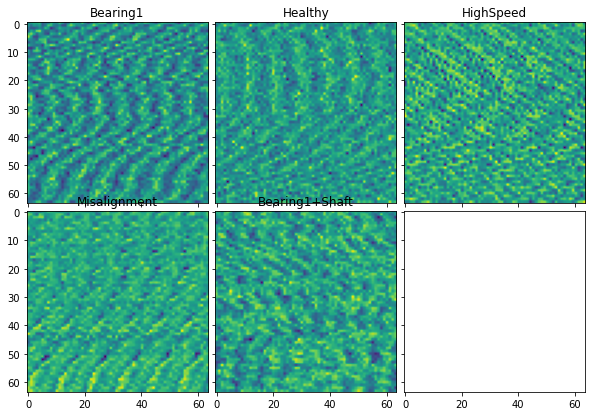

(158, 4096)
(40, 4096)
(99, 4096)


In [91]:
X_train, X_test, y_train, y_test = merge_vib_axis(data)
# Split training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2, random_state=sklearn_seed,
                                                  shuffle=False, stratify=None)
train_X, test_X, val_X, class_images = conv_to_images(X_train, X_test, X_val, N=1)

# convert labels to one-hot encoding
train_y = OneHot(y_train).swapaxes(1, 0)
test_y = OneHot(y_test).swapaxes(1, 0)
val_y = OneHot(y_val).swapaxes(1, 0)

# https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.argmax(train_y, axis=1)),
                                                 np.argmax(train_y, axis=1))
class_weight_dict = dict(enumerate(class_weights))


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

# Hyperparameters

In [79]:
# Set hyperparameters and optimizer
#batch_size = [1, 2, 4, 6, 16, 32, 64]
#batch_size = [16, 32, 64]
batch_size = [16]
#learning_rate = [1e-2, 1e-3, 2e-4]
learning_rate = [2e-4]
epochs = [2000]
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

# Run the Models

Running lenet with hyperparameters {'batch_size': 16, 'learning_rate': 0.0002, 'epochs': 2000, 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f755614ebd0>, 'loss': <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x7f755614ef50>, 'metrics': ['accuracy']}
https://app.neptune.ai/diegotheairwolf/knightec/e/KNIG-211
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
(158, 64, 64, 1)
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/2000
9/9 [==============================] - 4s 159ms/step - loss: 3.9958 - accuracy: 0.2014 - val_loss: 1.8301 - val_accuracy: 0.3000
Epoch 2/2000
9/9 [==============================] - 1s 36ms/step - loss: 1.6515 - accuracy: 0.3944 - val_loss: 1.5900 - val_accu

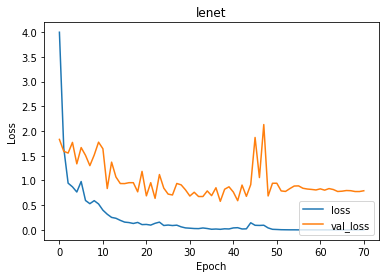

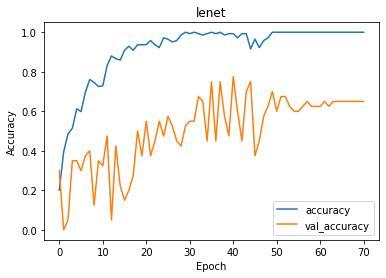

[[13  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0  1  0  0]
 [ 1  0  0  0  0]
 [ 0  8  0  0  4]]
              precision    recall  f1-score   support

           0      0.929     1.000     0.963        13
           1      0.619     1.000     0.765        13
           2      1.000     1.000     1.000         1
           3      0.000     0.000     0.000         1
           4      1.000     0.333     0.500        12

    accuracy                          0.775        40
   macro avg      0.710     0.667     0.646        40
weighted avg      0.828     0.775     0.736        40

[[26  4  0  0  0]
 [ 4 29  0  0  0]
 [ 0  0  2  0  1]
 [ 0  0  0  1  2]
 [ 0  7  0  0 23]]
              precision    recall  f1-score   support

           0      0.867     0.867     0.867        30
           1      0.725     0.879     0.795        33
           2      1.000     0.667     0.800         3
           3      1.000     0.333     0.500         3
           4      0.885     0.767     0.821        30

   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


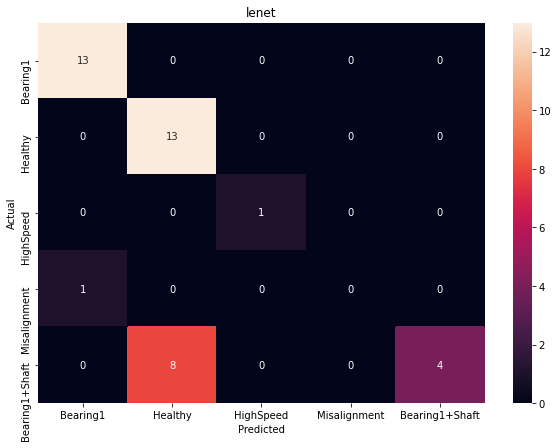

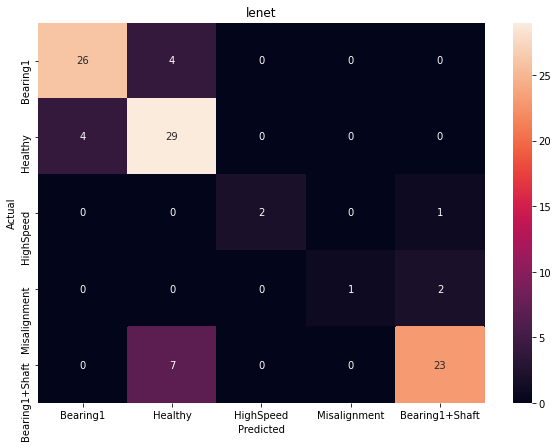

In [81]:
#models = [Xception, lenet, VGG16, MobileNetV2]

#models = [lenet, VGG16, MobileNetV2]
models = [lenet]

for b_size in batch_size:
  for l_r in learning_rate:
    for e in epochs:
      for idx, m in enumerate(models):
        model = keras.models.clone_model(m)
        optimizer = keras.optimizers.Adam(l_r)
        PARAMS = {"batch_size":b_size,
                "learning_rate":l_r,
                "epochs":e,
                "optimizer":optimizer,
                "loss":loss,
                "metrics":metrics}
        run_model(model, data, train_X, train_y, val_X, val_y, test_X, test_y, PARAMS)

In [ ]:
#%tensorboard --logdir logs/fit os.path(logdir)

In [ ]:
# # Save the entire model to a HDF5 file.
# # The '.h5' extension indicates that the model should be saved to HDF5.
# # current date and time
# now = datetime.now()
# timestamp = datetime.timestamp(now)
# model_name = timestamp
# model.save('{}.h5'.format(timestamp))